# Performance, profiling
### iteration and parallelization
9 July 2021<br>
NRSC 7657<br>
Daniel J Denman and John Thompson<br>
University of Colorado Anschutz<br>
<br>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,sys,glob

### iteration

Load some data to iterate over:

Serial exectution of cells 

In [2]:
a = 2

In [3]:
b= 2

In [4]:
c = a + b

Serial execution of some lines, through iteration     

In [5]:
for i in range(10):
#     c=a+b + i
    print(i)
#     print(c)

0
1
2
3
4
5
6
7
8
9


Serial execution of the same lines in the iteration, done in cells

In [6]:
print(0)

0


In [7]:
print(1)

1


In [8]:
print(2)

2


In [9]:
print(3)

3


In [10]:
print(4)

4


In [11]:
print(5)

5


In [12]:
print(6)

6


In [13]:
print(7)

7


In [14]:
print(8)

8


In [15]:
print(9)

9


# Performance
you will likely notice that some code is slow. for example:

In [16]:
from time import sleep

In [17]:
for i in range(100):
    for j in range(100):
        a= 4
        sleep(0.002)

This is slow because we made it slow, with a `sleep()` call that pauses the execution of code for 2 msec every iteration. <br><br>
I am sure you all know and maybe have code of your own that is also slow. That is especially the nature of the beast if you are serially iterating over large amount of data (which can be ephys traces, images, or large matrices such as Seq data). Here we'll try to do some stuff with some ephys data, but many of the same principles apply

In [46]:
df = pd.read_csv('/Volumes/DATA5/20210525_c41_ABC_g0/dansort/cluster_info.tsv',sep='\t')

In [47]:
#make it huge so it takes time, for demonstration
df = pd.concat([df]*100,ignore_index=True)

In [21]:
df.head()

,id,Amplitude,ContamPct,KSLabel,amplitude,channel,depth,firing_rate,group,n_spikes,shank
0,0,31.8,100.0,mua,1.845319,0,20.0,0.3 spk/s,NaN,1833,0
1,1,50.5,100.0,mua,2.312337,1,20.0,3.4 spk/s,noise,20244,0
2,2,32.2,100.0,mua,2.041949,3,40.0,2.6 spk/s,NaN,15763,0
3,3,40.9,0.8,good,3.062917,1,20.0,8.2 spk/s,good,49401,0
4,4,28.7,100.0,mua,1.955942,5,60.0,3.5 spk/s,NaN,21074,0


how many "cells" have an amplitude > 100 µV? let's iterate over the `df` serially:

In [22]:
# %%timeit
cell_ids=[]
for i in range(df.shape[0]):
    if df.Amplitude[i] > 100.:
        cell_ids.extend([df.id[i]])

In [23]:
len(cell_ids)

3500

how do we speed this iteration up? out list of strategies:
- Sorting tuples
- filtering
- Built-in methods
- List comprehension
- Avoiding it (but don’t try too hard unless you need to)

list comprehension

In [24]:
# %%timeit
cell_ids_listcomp = [df.id[i] for i in range(df.shape[0]) if df.Amplitude[i] > 100.]

In [25]:
len(cell_ids_listcomp)

3500

sorting

In [26]:
df.sort_values(by='Amplitude',inplace=True,ascending=False,ignore_index=True)

In [27]:
df.head()

,id,Amplitude,ContamPct,KSLabel,amplitude,channel,depth,firing_rate,group,n_spikes,shank
0,142,294.1,0.0,good,6.455642,77,780.0,17.3 spk/s,NaN,104315,0
1,142,294.1,0.0,good,6.455642,77,780.0,17.3 spk/s,NaN,104315,0
2,142,294.1,0.0,good,6.455642,77,780.0,17.3 spk/s,NaN,104315,0
3,142,294.1,0.0,good,6.455642,77,780.0,17.3 spk/s,NaN,104315,0
4,142,294.1,0.0,good,6.455642,77,780.0,17.3 spk/s,NaN,104315,0


In [28]:
# %%timeit
cell_ids_sort=[]
for i in range(df.shape[0]):
    if df.Amplitude[i] > 100.:
        cell_ids_sort.extend([df.id[i]])
    else: break

In [29]:
len(cell_ids_sort)

3500

filtering (and built-ins)

In [30]:
# %%timeit
df_cell_ids_filter = df[df.Amplitude > 100.].Amplitude

In [31]:
len(df_cell_ids_filter)

3500

## all of those approaches do the job
and all produce the same resullt, but some seem to do it faster. how much faster?
<br>

# Profiling 
To figure out what is taking a long time, we do what is called "profiling". This is a like debugging, but instead of _"is this bit of code broken?"_ the question is _"how long does this bit of code take?"_
<br><br>
This is something that jupyter is designed to naturally highlight. we already have a feeling for this. instead of a script that did the above, which might look something like this:

In [ ]:
#serial
cell_ids=[]
for i in range(df.shape[0]):
    if df.Amplitude[i] > 100.:
        cell_ids.extend([df.id[i]])
        
#list comprehension
cell_ids_listcomp = [df.id[i] for i in range(df.shape[0]) if df.Amplitude[i] > 100.]

#sort
df.sort_values(by='Amplitude',inplace=True,ascending=False,ignore_index=True)
cell_ids_sort=[]
for i in range(df.shape[0]):
    if df.Amplitude[i] > 100.:
        cell_ids_sort.extend([df.id[i]])
    else: break

#built-in / filtering
df_cell_ids_filter = df[df.Amplitude > 100.].Amplitude

this cell, or a script that was executing the lines in this cell, would just silently take a long time. <br><br>
With a cell, you naturally break your code into small enough chunks that you can see what is happening as you go. This will also give you a _sense_ of what is slow code, but maybe not exactly how slow it is. 

To time things, there are several options, including the `time` module which has several counters and `timeit`. in jupyter the `%%time` and `%%timeit` magics do this

# Another example
### and on to parallel computing

In [33]:
# load some data
lfp_data = np.fromfile('/Volumes/DATA5/20210525_c41_ABC_g0/20210525_c41_ABC_g0_t0.imec0.lf.bin',dtype=np.int16)

KeyboardInterrupt: 

In [2]:
# load some data
lfp_data = np.memmap('/Volumes/DATA5/20210525_c41_ABC_g0/20210525_c41_ABC_g0_t0.imec0.lf.bin',
                    dtype=np.int16, mode='r')

In [3]:
lfp_data.shape[0]/385

15066994.0

In [4]:
lfp_data.reshape(385,int(lfp_data.shape[0]/385))

memmap([[  52,   -1,    7, ...,  -49,  -56,  -58],
        [ -40,  -13,  -44, ...,  -96,  -68,  -66],
        [ -51,  -73,  -62, ...,    1,  -20,  -20],
        ...,
        [   0,   -5,   23, ..., -128, -120, -127],
        [ -98, -103,  -98, ...,  131,  169,  171],
        [ 171,  153,  138, ...,   18,    1,   64]], dtype=int16)

In [5]:
lfp_data = lfp_data.reshape(385,int(lfp_data.shape[0]/385))[:384]

In [6]:
lfp_data.shape

(384, 15066994)

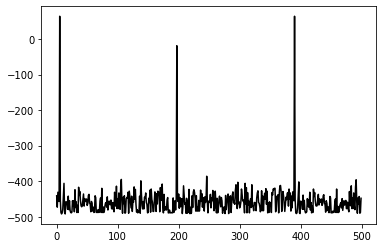

In [7]:
plt.plot(lfp_data[101,:500],'k')
# plt.plot(lfp_data[110,:500],'k',alpha=0.5)

In [8]:
chunk_of_lfp = lfp_data[:384,5000:10000]

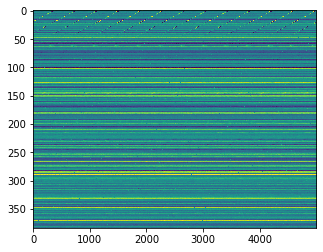

In [45]:
plt.figure(figsize=(10,4))
plt.imshow(chunk_of_lfp)
plt.gca().set_aspect(10)

In [46]:
mean_corrected = np.mean(chunk_of_lfp,1)
chunk_of_lfp = np.transpose(np.subtract(chunk_of_lfp.T, mean_corrected))

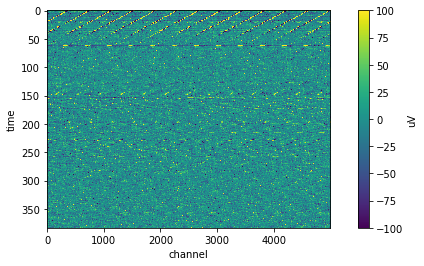

In [54]:
plt.figure(figsize=(10,4))
plt.imshow(chunk_of_lfp,clim=(-100,100))
plt.gca().set_aspect(10)
plt.ylabel('time')
plt.xlabel('channel')
plt.colorbar(label='uV')

In [48]:
np.shape(chunk_of_lfp)

(384, 5000)

can we find all the places where the deflection is greater than 100 µV in one time step, since these are likely to be outliers. 

In [90]:
%%timeit
indexes = []
#one way to do this would be to iterate over the rows and columns:
for i in np.arange(0,np.shape(chunk_of_lfp)[0]):
    for j in np.arange(1,np.shape(chunk_of_lfp)[1]):
        if np.abs(chunk_of_lfp[i][j] - chunk_of_lfp[i][j-1]) > 100:
            indexes.append((i,j))

4.85 s ± 246 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Informative progress printing
a way to build some intuition for what is taking so long is making sure you beefy iterations are always telling you what is going on. If you have your telling where it is and what the status is at some regularity, you might be able to check why things are taking so long. 
<br><br>
This is especially useful if you have a messy nested for loop (...which is fine, as long as it is not actually causing too much slow down for your _scientific_ progress)

In [112]:
np.shape(chunk_of_lfp)

(384, 5000)

In [113]:
for i in np.arange(0,np.shape(chunk_of_lfp)[0]):
    for j in np.arange(1,np.shape(chunk_of_lfp)[1]):
        if np.abs(chunk_of_lfp[i][j] - chunk_of_lfp[i][j-1]) > 100:
            print('we are on row '+str(i)+' and column '+str(j),end="\r")
            indexes.append((i,j))

`tqdm` - for making nice progress bars

In [6]:
import tqdm, time

In [117]:
for i in tqdm.tqdm(range(100)):
    for j in range(100):
        a= 4
        time.sleep(0.002)

100%|██████████| 100/100 [00:24<00:00,  4.11it/s]


In [21]:
#tqdm messages

can also do this nested:

In [120]:
for i in tqdm.tqdm(range(100)):
    for j in tqdm.tqdm(range(100)):
        a= 4
        time.sleep(0.001)

100%|██████████| 100/100 [00:13<00:00,  7.64it/s]


but this is ugly and cumbersome. `tqdm` has jupyter specific versions that work _much_ better in the notebook:

In [123]:
for i in tqdm.tqdm_notebook(range(100)):
    for j in tqdm.notebook.tqdm(range(100)):
        a= 4
        time.sleep(0.002)
        

In [124]:
for i in tqdm.notebook.tqdm(np.arange(0,np.shape(chunk_of_lfp)[0])):
    for j in np.arange(1,np.shape(chunk_of_lfp)[1]):
        if np.abs(chunk_of_lfp[i][j] - chunk_of_lfp[i][j-1]) > 100:
            print('we are on row '+str(i)+' and column '+str(j),end="\r")
            indexes.append((i,j))

we are on row 383 and column 4663


In [126]:
for i in tqdm.notebook.tqdm(np.arange(0,np.shape(chunk_of_lfp)[0]),desc="Channel Iteration"):
    for j in np.arange(1,np.shape(chunk_of_lfp)[1]):
        if np.abs(chunk_of_lfp[i][j] - chunk_of_lfp[i][j-1]) > 100:
            indexes.append((i,j))


we are on row 383 and column 4663


use a built in:

In [136]:
np.where(chunk_of_lfp>100)[1].shape

(12657,)

In [150]:
np.shape(indexes)

(140936, 2)

In [151]:
%%timeit
np.where(np.abs(np.diff(chunk_of_lfp,axis=1))>100)[1].shape

14.2 ms ± 195 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Parallel computing
`multiprocessing`, `joblib`, `asyncio`  and `dask`

In [55]:
#come with standard python
import multiprocessing, asyncio

In [42]:
#need to install
!conda install joblib dask -y

Solving environment: done

## Package Plan ##

  environment location: /Users/danieljdenman/opt/anaconda3/envs/NRSC7657

  added / updated specs:
    - dask
    - joblib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bokeh-2.3.3                |   py38hecd8cb5_0         5.9 MB
    ca-certificates-2021.7.5   |       hecd8cb5_1         113 KB
    click-8.0.1                |     pyhd3eb1b0_0          79 KB
    cloudpickle-1.6.0          |             py_0          30 KB
    cytoolz-0.11.0             |   py38haf1e3a3_0         294 KB
    dask-2021.6.2              |     pyhd3eb1b0_0           5 KB
    dask-core-2021.6.2         |     pyhd3eb1b0_0         692 KB
    distributed-2021.6.2       |   py38hecd8cb5_0         1.1 MB
    fsspec-2021.6.0            |     pyhd3eb1b0_0          88 KB
    joblib-1.0.1               |     pyhd3eb1b0_0         208 KB
    locket-0.2.1               |  

In [56]:
import joblib, dask

Why so many? <br>
In most cases, any one of these packages could be used, and in many cases any one of them would speed up your code. As covered in the slides, each has it's own strengths: 
- `multiprocessing` and `joblib` are good for embarassingly parallel tasks, which are CPU-limited
- `asyncio` is most appropriate for I/O-limited, things that are slowed down by reading or writing from disk 
- `dask` is also good for CPU-limited; it is a little more tricky to implement than joblib, but has good integration with the packages you would use (`numpy`, `pandas`, `xarray`)
<br><br>
We go through an example with each one here, to compare them and build some intuition for when they might be useful. 
**note:** these are note the easiest packages to use; this is largely because of a design choice in python (the GIL) which tries to force things to run one at a time

<br>

`joblib`

In [71]:
from joblib import Parallel, delayed

In [72]:
from math import sqrt

In [102]:
%%timeit
[sqrt(i ** 2) for i in range(10)]

3.44 µs ± 182 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [103]:
%%timeit
Parallel(n_jobs=12)(delayed(sqrt)(i ** 2) for i in range(10))

5.65 ms ± 167 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Let's try to speed up our finding of peaks in the ephys data<br>
as a reminder, we got a chunk of LFP data and it takes this long to do it with a nested loop (we're going to make it a little bigger chunk)

In [93]:
chunk_of_lfp = lfp_data[:384,5000:15000]

In [94]:
%%time
indexes = []
#one way to do this would be to iterate over the rows and columns:
for i in np.arange(0,np.shape(chunk_of_lfp)[0]):
    for j in np.arange(1,np.shape(chunk_of_lfp)[1]):
        if np.abs(chunk_of_lfp[i][j] - chunk_of_lfp[i][j-1]) > 100:
            indexes.append((i,j))

CPU times: user 32.3 s, sys: 322 ms, total: 32.7 s
Wall time: 32.5 s


We need to make our own function to pass to any parallel package, and an iterable to iterate over. it will dive the iterable over the "workers", have each worker use the function on its bit of the iterable, and collect the results:

In [95]:
def find_peaks(channel):
#     print(channel)
    indexes = []
    i=int(channel)
#     for i in tqdm.tqdm_notebook(np.arange(0,np.shape(chunk_of_lfp)[0]),desc="Channel Iteration"):
    for j in np.arange(1,np.shape(chunk_of_lfp)[1]):
        if np.abs(chunk_of_lfp[i][j] - chunk_of_lfp[i][j-1]) > 100:
            indexes.append((i,j))
#     print(i)
    return indexes

In [98]:
%%time
indexes_p = Parallel(n_jobs=10)(delayed(find_peaks)(channel) for channel in np.arange(0,383))

CPU times: user 254 ms, sys: 19.2 ms, total: 273 ms
Wall time: 2.53 s


<br>

<br>


`asyncio`

In [1]:
import asyncio

In [10]:
def load():
    lfp_data = np.fromfile('/Volumes/DATA5/20210525_c41_ABC_g0/20210525_c41_ABC_g0_t0.imec0.lf.bin',dtype=np.int16)
    return lfp_data

In [ ]:
d=asyncio.run(load())

<br>

<br>

`dask`

In [9]:
from dask.distributed import Client, progress
client = Client(processes=False, threads_per_worker=4,
                n_workers=10, memory_limit='2GB')
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://10.33.237.12:8787/status,
Status: running,Using processes: False
Dashboard: http://10.33.237.12:8787/status,Workers: 10
Total threads: 40,Total memory: 18.63 GiB
Comm: inproc://10.33.237.12/33846/1,Workers: 10
Dashboard: http://10.33.237.12:8787/status,Total threads: 40
Started: Just now,Total memory: 18.63 GiB
Comm: inproc://10.33.237.12/33846/6,Total threads: 4
Dashboard: http://10.33.237.12:60332/status,Memory: 1.86 GiB
Nanny: None,


In [10]:
import dask.array as da

In [11]:
x = da.from_array(chunk_of_lfp,chunks=100)

In [12]:
x

dask.array<array, shape=(384, 5000), dtype=int16, chunksize=(100, 100), chunktype=numpy.ndarray>

In [13]:
z = np.where(np.abs(np.diff(x,axis=1))>100)[1]
z

dask.array<getitem, shape=(nan,), dtype=int64, chunksize=(nan,), chunktype=numpy.ndarray>

In [17]:
%%time
indexes_dask = z.compute()

CPU times: user 3.57 s, sys: 230 ms, total: 3.8 s
Wall time: 3.68 s


In [18]:
np.shape(indexes_dask)

(15586,)

dask with pandas - mostly for really big Seq datasets, in the neuroscience context. would use dask.array for image or ephys data

In [2]:
df = pd.read_csv('/Volumes/DATA5/20210525_c41_ABC_g0/dansort/cluster_info.tsv',sep='\t')
df = pd.concat([df]*100,ignore_index=True)
df = pd.concat([df]*100,ignore_index=True) #make it even bigger
df.to_csv('/Users/danieljdenman/github/NRSC7657/Week5/bigdf.csv')

serially with `pandas` takes a while

In [3]:
%%time
df_cell_ids_filter = df[df.Amplitude > 100.].Amplitude

CPU times: user 274 ms, sys: 155 ms, total: 428 ms
Wall time: 423 ms


In [49]:
import dask.dataframe as dd

In [60]:
df.shape

(3370000, 11)

In [66]:
df_d = dd.from_pandas(df,npartitions = 500)

In [67]:
a = df_d[df_d.Amplitude > 100.].Amplitude

In [68]:
%%time
df_cell_ids_filter=a.compute()

CPU times: user 2.86 s, sys: 359 ms, total: 3.22 s
Wall time: 2.86 s


In [71]:
df_cell_ids_filter.shape

(350000,)

`multiprocessing`

In [84]:
def find_peaks(channel):
#     print(channel)
    indexes = []
    i=int(channel)
#     for i in tqdm.tqdm_notebook(np.arange(0,np.shape(chunk_of_lfp)[0]),desc="Channel Iteration"):
    for j in np.arange(1,np.shape(chunk_of_lfp)[1]):
        if np.abs(chunk_of_lfp[i][j] - chunk_of_lfp[i][j-1]) > 100:
            indexes.append((i,j))
#     print(i)
    return indexes

In [58]:
import multiprocessing as mp
num_processes = mp.cpu_count()
print("Number of cpu : ", num_processes)

Number of cpu :  12


In [59]:
pool = mp.Pool(num_processes)

In [67]:
a = pool.map(find_peaks,np.arange(0,383))


KeyboardInterrupt



In [80]:
if __name__ ==  '__main__': 
    pool = multiprocessing.Pool()
    results = pool.map(find_peaks, np.arange(0,383))
    pool.close()
    pool.join()
    print(results)

KeyboardInterrupt: 

In [65]:
import tqdm